In [15]:
# pip install protobuf==3.20.x

In [16]:
pip install scikit-survival

In [17]:
!pip install python-dotenv

In [18]:
!pip install Boto3

In [21]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px

# Deep Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

#Survival Analysis
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import cumulative_dynamic_auc

from dotenv import load_dotenv
load_dotenv('/content/drive/MyDrive/Projet JEDHA/.env')
import boto3
import os
import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
session = boto3.Session(aws_access_key_id=os.environ["AWS_ACCESS_KEY"],
                        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"])

s3 = session.client("s3")
obj = s3.get_object(Bucket="les-derniers-flocons-project", Key='donnees_meteo_avec_stations_et_altitudes_selection.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.head()

<ipython-input-22-fd39b8cead1f>:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(obj['Body'].read()))


,Unnamed: 0,date,latitude,longitude,temperature_2m_mean,snowfall_sum,rain_sum,cloud_cover_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,snowfall_water_equivalent_sum,wind_speed_10m_mean,soil_temperature_0_to_100cm_mean,station,state,closed_year,altitude
0,0,1970-01-01 00:00:00+00:00,45.75733,6.539447,-11.113585,0.350000,0.0,86.125000,-7.5865,-15.836500,23662.752,0.500000,2.350192,1.267938,Les Saisies,open,NaN,1650
1,1,1970-01-02 00:00:00+00:00,45.75733,6.539447,-11.553166,0.280000,0.0,37.208332,-7.7865,-14.886500,26720.627,0.400000,3.597091,1.246875,Les Saisies,open,NaN,1650
2,2,1970-01-03 00:00:00+00:00,45.75733,6.539447,-10.353168,0.000000,0.0,0.833333,-5.0865,-13.886500,27070.027,0.000000,4.800602,1.206521,Les Saisies,open,NaN,1650
3,3,1970-01-04 00:00:00+00:00,45.75733,6.539447,-10.469832,8.679999,0.8,82.833336,-5.4865,-17.186499,0.000,12.400000,7.479843,1.176584,Les Saisies,open,NaN,1650
4,4,1970-01-05 00:00:00+00:00,45.75733,6.539447,-5.276083,7.280001,3.0,85.833336,-3.3865,-7.386500,7230.934,10.400001,5.963974,1.155417,Les Saisies,open,NaN,1650


In [23]:
# Take dates > 1990
df = df[df["date"] > "1990-01-01 00:00:00+00:00"]

In [24]:
# Transform to datatime
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S%z')
df['date'] = df['date'].dt.strftime('%d/%m/%Y')
df['date'] = pd.to_datetime(df['date'],format="%d/%m/%Y")

In [25]:
# Arrange
df = df.drop('Unnamed: 0',axis=1)
df = df.set_index('date')
df = df.sort_values(by='date')

In [26]:
# Clean "Altitude"
df["altitude"] = df["altitude"].astype(str)
df["altitude"] = df["altitude"].str.replace(" ", "").str.replace(",", ".")
df["altitude"] = df["altitude"].astype(float)

In [27]:
dates_fermeture = {
    'Brison': pd.Timestamp('2008'),
    'Burzier': pd.Timestamp('1999'),
    'Col du Plainpalais' : pd.Timestamp('2019'),
    "Crey Rond" : pd.Timestamp('2000'),
    "Drouzin-Le-Mont" : pd.Timestamp('2012'),
    "Granier sur Aime" :pd.Timestamp('2017'),
    "La Sambuy" : pd.Timestamp('2023'),
    "Les Bossons - Chamonix" :pd.Timestamp('2023'),
    "Notre Dame du pré" : pd.Timestamp('2024'),
    "Saint-Jean de Sixt" : pd.Timestamp('2023'),
    "Saxel" : pd.Timestamp('2000'),
    "Sixt Fer à Cheval" : pd.Timestamp('2017'),
    "Verthemex - Mont du Chat" : pd.Timestamp('2000')
}
df = df.reset_index()
df['date_limite'] = df['station'].map(dates_fermeture)
mask = df['date_limite'].isna() | (df['date'] <= df['date_limite'])
df = df[mask].drop('date_limite',axis=1)

df = df.set_index(['date'])

In [28]:
# Plot (in comments because its too long)
# parameters = ["temperature_2m_mean","snowfall_sum","rain_sum","cloud_cover_mean","temperature_2m_max","temperature_2m_min","sunshine_duration","snowfall_water_equivalent_sum","wind_speed_10m_mean","soil_temperature_0_to_100cm_mean"]

# for parameter in parameters:
#     fig = px.line(df[parameter],width=1000,height=600)
#     fig.show()

# Survival Analysis

## Only with snowfall

In [29]:
# Create df
df_survival = df.copy().reset_index()
df_survival.loc[df_survival['closed_year'] == 2125, 'closed_year'] = np.nan

In [30]:
# Group per station
df_survival["date"] = pd.to_datetime(df_survival["date"])
df_survival['year'] = df_survival["date"].dt.year

In [31]:
# Separate data in train/val
stations_ouvertes = df_survival.loc[df_survival["state"] == 'open']
stations_fermees = df_survival.loc[df_survival["state"] == 'closed']

stations_ouvertes = stations_ouvertes['station'].unique()
stations_fermees = stations_fermees['station'].unique()

# 80%
stations_ouvertes_sample = pd.Series(stations_ouvertes).sample(frac=0.8, random_state=42,replace = False)
stations_fermees_sample = pd.Series(stations_fermees).sample(frac=0.8, random_state=42,replace = False)

# 20%
stations_ouvertes_val = pd.Series(list(set(stations_ouvertes) - set(stations_ouvertes_sample)))
stations_fermees_val = pd.Series(list(set(stations_fermees) - set(stations_fermees_sample)))

train_df = df_survival[df_survival['station'].isin(list(stations_ouvertes_sample) + list(stations_fermees_sample))]
val_df = df_survival[df_survival['station'].isin(list(stations_ouvertes_val) + list(stations_fermees_val))]

print(f"Train set : {train_df.shape}")
print(f"Validation set : {val_df.shape}")

Train set : (268190, 18)
Validation set : (70729, 18)


In [32]:
#Val DF
grouped = val_df.groupby(["year", "station"])
val_df = grouped.agg({
    "state": "first",
    "date": ["min", "max"],
    "closed_year": "first",
    "temperature_2m_mean": "mean",
    "snowfall_sum": "mean",
    "rain_sum": "mean",
    "altitude": "first",
    "cloud_cover_mean": "mean",
    "sunshine_duration": "mean",
    "wind_speed_10m_mean": "mean",
    "soil_temperature_0_to_100cm_mean": "mean"
})

# Rename columns
val_df.columns = [
    "state", "open_date", "last_obs_date", "closed_year",
    "temperature_2m_mean", "snowfall_sum", "rain_sum", "altitude",
    "cloud_cover_mean", "sunshine_duration", "wind_speed_10m_mean",
    "soil_temperature_0_to_100cm_mean"
]

val_df = val_df.reset_index()

val_df["event"] = val_df["closed_year"].notna()

# Use the real date
val_df["closed_date"] = pd.to_datetime(val_df["closed_year"].dropna().astype(int), format="%Y", errors='coerce') \
    .reindex(val_df.index)
val_df["closed_date"] = val_df["closed_date"].where(val_df["event"], val_df["last_obs_date"])

# Time in years
val_df["duration"] = (val_df["closed_date"] - val_df["open_date"]).dt.days/365.25
val_df = val_df[val_df["duration"] >= 0]

# Target
y_val = Surv.from_arrays(event=val_df["event"], time=val_df["duration"])

# Features
features = ["snowfall_sum"]
X = val_df[features]
X_val_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=features, index=val_df.index)

print(X_val_scaled.shape)
print(y_val.shape)

(200, 1)
(200,)


In [33]:
#Train DF
grouped = train_df.groupby(["year", "station"])
train_df = grouped.agg({
    "state": "first",
    "date": ["min", "max"],
    "closed_year": "first",
    "temperature_2m_mean": "mean",
    "snowfall_sum": "mean",
    "rain_sum": "mean",
    "altitude": "first",
    "cloud_cover_mean": "mean",
    "sunshine_duration": "mean",
    "wind_speed_10m_mean": "mean",
    "soil_temperature_0_to_100cm_mean": "mean"
})

# Rename columns
train_df.columns = [
    "state", "open_date", "last_obs_date", "closed_year",
    "temperature_2m_mean", "snowfall_sum", "rain_sum", "altitude",
    "cloud_cover_mean", "sunshine_duration", "wind_speed_10m_mean",
    "soil_temperature_0_to_100cm_mean"
]

train_df = train_df.reset_index()

train_df["event"] = train_df["closed_year"].notna()


# Use the real date
train_df["closed_date"] = pd.to_datetime(train_df["closed_year"].dropna().astype(int), format="%Y", errors='coerce') \
    .reindex(train_df.index)
train_df["closed_date"] = train_df["closed_date"].where(train_df["event"], train_df["last_obs_date"])

# Time in years
train_df["duration"] = (train_df["closed_date"] - train_df["open_date"]).dt.days/365.25
train_df = train_df[train_df["duration"] >= 0]

# Cibles
y_train = Surv.from_arrays(event=train_df["event"], time=train_df["duration"])

# Features
features = ["snowfall_sum"]
X = train_df[features]
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=features, index=train_df.index)

print(X_train_scaled.shape)
print(y_train.shape)

(756, 1)
(756,)


In [34]:
# Training CoxPH
cox = CoxPHSurvivalAnalysis().fit(X_train_scaled, y_train)

In [35]:
# Concordance Index
cindex_train = concordance_index_censored(
    train_df["event"].values,
    train_df["duration"].values,
    cox.predict(X_train_scaled)
)
cindex_val = concordance_index_censored(
    val_df["event"].values,
    val_df["duration"].values,
    cox.predict(X_val_scaled)
)

print(f"[Cox] C-index Train : {cindex_train[0]:.3f}")
print(f"[Cox] C-index Test  : {cindex_val[0]:.3f}")

[Cox] C-index Train : 0.610
[Cox] C-index Test  : 0.564


In [36]:
coefs = pd.Series(cox.coef_, index=X_val_scaled.columns)
print(coefs.sort_values())

snowfall_sum   -0.218184
dtype: float64


Cox model modelise the relative risk.
La neige est protectrice : elle est associée à une réduction du risque (donc à une durée de survie plus longue).


In [37]:
times = np.arange(1, 6)  # AUC 1, 2, 3, 4 et 5 years

# AUC dynamics
auc_values, mean_auc = cumulative_dynamic_auc(
    y_train, y_val, cox.predict(X_val_scaled), times
)

for t, auc in zip(times, auc_values):
    print(f"AUC à {t:.1f} ans : {auc:.3f}")

AUC à 1.0 ans : 0.414
AUC à 2.0 ans : 0.398
AUC à 3.0 ans : 0.450
AUC à 4.0 ans : 0.387
AUC à 5.0 ans : 0.344


Pas de résultats concluant on préfère tester avec toutes les features

##Avec toutes les features

In [38]:
# Create df
df_survival = df.copy().reset_index()
df_survival.loc[df_survival['closed_year'] == 2125, 'closed_year'] = np.nan

In [39]:
# Group per station
df_survival["date"] = pd.to_datetime(df_survival["date"])
df_survival['year'] = df_survival["date"].dt.year

In [40]:
# Separate data in train/val
stations_ouvertes = df_survival.loc[df_survival["state"] == 'open']
stations_fermees = df_survival.loc[df_survival["state"] == 'closed']

stations_ouvertes = stations_ouvertes['station'].unique()
stations_fermees = stations_fermees['station'].unique()

# 80%
stations_ouvertes_sample = pd.Series(stations_ouvertes).sample(frac=0.8, random_state=42,replace = False)
stations_fermees_sample = pd.Series(stations_fermees).sample(frac=0.8, random_state=42,replace = False)

# 20%
stations_ouvertes_val = pd.Series(list(set(stations_ouvertes) - set(stations_ouvertes_sample)))
stations_fermees_val = pd.Series(list(set(stations_fermees) - set(stations_fermees_sample)))

train_df = df_survival[df_survival['station'].isin(list(stations_ouvertes_sample) + list(stations_fermees_sample))]
val_df = df_survival[df_survival['station'].isin(list(stations_ouvertes_val) + list(stations_fermees_val))]

print(f"Train set : {train_df.shape}")
print(f"Validation set : {val_df.shape}")

Train set : (268190, 18)
Validation set : (70729, 18)


In [41]:
#Val DF
grouped = val_df.groupby(["year", "station"])
val_df = grouped.agg({
    "state": "first",
    "date": ["min", "max"],
    "closed_year": "first",
    "temperature_2m_mean": "mean",
    "snowfall_sum": "mean",
    "rain_sum": "mean",
    "altitude": "first",
    "cloud_cover_mean": "mean",
    "sunshine_duration": "mean",
    "wind_speed_10m_mean": "mean",
    "soil_temperature_0_to_100cm_mean": "mean",
    "latitude": "first",
    "longitude": "first"
})


# Rename columns
val_df.columns = [
    "state", "open_date", "last_obs_date", "closed_year",
    "temperature_2m_mean", "snowfall_sum", "rain_sum", "altitude",
    "cloud_cover_mean", "sunshine_duration", "wind_speed_10m_mean",
    "soil_temperature_0_to_100cm_mean","latitude","longitude"
]

val_df = val_df.reset_index()

val_df["event"] = val_df["closed_year"].notna()

# Use real date
val_df["closed_date"] = pd.to_datetime(val_df["closed_year"].dropna().astype(int), format="%Y", errors='coerce') \
    .reindex(val_df.index)
val_df["closed_date"] = val_df["closed_date"].where(val_df["event"], val_df["last_obs_date"])

# Time in years
val_df["duration"] = (val_df["closed_date"] - val_df["open_date"]).dt.days/365.25
val_df = val_df[val_df["duration"] >= 0]

# Target
y_val = Surv.from_arrays(event=val_df["event"], time=val_df["duration"])

# Features
features = ["snowfall_sum", "rain_sum","cloud_cover_mean","sunshine_duration", "wind_speed_10m_mean","soil_temperature_0_to_100cm_mean","temperature_2m_mean"]
X = val_df[features]
X_val_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=features, index=val_df.index)

print(X_val_scaled.shape)
print(y_val.shape)

(200, 7)
(200,)


In [42]:
#Train DF
grouped = train_df.groupby(["year", "station"])
train_df = grouped.agg({
    "state": "first",
    "date": ["min", "max"],
    "closed_year": "first",
    "temperature_2m_mean": "mean",
    "snowfall_sum": "mean",
    "rain_sum": "mean",
    "altitude": "first",
    "cloud_cover_mean": "mean",
    "sunshine_duration": "mean",
    "wind_speed_10m_mean": "mean",
    "soil_temperature_0_to_100cm_mean": "mean",
    "latitude": "first",
    "longitude": "first"
})

# Rename columns
train_df.columns = [
    "state", "open_date", "last_obs_date", "closed_year",
    "temperature_2m_mean", "snowfall_sum", "rain_sum", "altitude",
    "cloud_cover_mean", "sunshine_duration", "wind_speed_10m_mean",
    "soil_temperature_0_to_100cm_mean","latitude","longitude"
]

train_df = train_df.reset_index()

train_df["event"] = train_df["closed_year"].notna()

# Use real date
train_df["closed_date"] = pd.to_datetime(train_df["closed_year"].dropna().astype(int), format="%Y", errors='coerce') \
    .reindex(train_df.index)
train_df["closed_date"] = train_df["closed_date"].where(train_df["event"], train_df["last_obs_date"])

# Time in years
train_df["duration"] = (train_df["closed_date"] - train_df["open_date"]).dt.days/365.25
train_df = train_df[train_df["duration"] >= 0]

# Target
y_train = Surv.from_arrays(event=train_df["event"], time=train_df["duration"])

# Features
features = ["snowfall_sum", "rain_sum","cloud_cover_mean","sunshine_duration", "wind_speed_10m_mean","soil_temperature_0_to_100cm_mean","temperature_2m_mean"]
X = train_df[features]
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=features, index=train_df.index)

print(X_train_scaled.shape)
print(y_train.shape)

(756, 7)
(756,)


In [43]:
# Training  CoxPH
cox = CoxPHSurvivalAnalysis().fit(X_train_scaled, y_train)

In [44]:
# Concordance Index
cindex_train = concordance_index_censored(
    train_df["event"].values,
    train_df["duration"].values,
    cox.predict(X_train_scaled)
)
cindex_val = concordance_index_censored(
    val_df["event"].values,
    val_df["duration"].values,
    cox.predict(X_val_scaled)
)

print(f"[Cox] C-index Train : {cindex_train[0]:.3f}")
print(f"[Cox] C-index Test  : {cindex_val[0]:.3f}")

[Cox] C-index Train : 0.688
[Cox] C-index Test  : 0.736


Mesure la capacité du modèle à bien ordonner les durées de survie.


In [45]:
# Coefficients bruts (beta)
coef = cox.coef_

# Hazard Ratios = exp(beta)
hazard_ratios = np.exp(coef)

results = pd.DataFrame({
    'variable': X_val_scaled.columns,
    'coef (β)': coef,
    'HR (exp(β))': hazard_ratios
})

display(results)

,variable,coef (β),HR (exp(β))
0,snowfall_sum,-0.200555,0.818276
1,rain_sum,-0.926379,0.395985
2,cloud_cover_mean,-0.005338,0.994677
3,sunshine_duration,-0.662911,0.515349
4,wind_speed_10m_mean,-0.176595,0.838119
5,soil_temperature_0_to_100cm_mean,0.456381,1.578352
6,temperature_2m_mean,0.154227,1.166756


Le Hazard Ratio (HR) compare le risque instantané qu’un événement se produise si <1 = le risque est réduit si >1 le risque est augmenté.






In [46]:
times = np.arange(1, 33)

auc_values, mean_auc = cumulative_dynamic_auc(
    y_train, y_val, cox.predict(X_val_scaled), times
)
for t, auc in zip(times, auc_values):
    print(f"AUC à {t:.1f} ans : {auc:.3f}")

AUC à 1.0 ans : 0.707
AUC à 2.0 ans : 0.649
AUC à 3.0 ans : 0.670
AUC à 4.0 ans : 0.695
AUC à 5.0 ans : 0.647
AUC à 6.0 ans : 0.694
AUC à 7.0 ans : 0.646
AUC à 8.0 ans : 0.663
AUC à 9.0 ans : 0.684
AUC à 10.0 ans : 0.671
AUC à 11.0 ans : 0.671
AUC à 12.0 ans : 0.663
AUC à 13.0 ans : 0.688
AUC à 14.0 ans : 0.717
AUC à 15.0 ans : 0.717
AUC à 16.0 ans : 0.690
AUC à 17.0 ans : 0.686
AUC à 18.0 ans : 0.719
AUC à 19.0 ans : 0.719
AUC à 20.0 ans : 0.797
AUC à 21.0 ans : 0.780
AUC à 22.0 ans : 0.742
AUC à 23.0 ans : 0.742
AUC à 24.0 ans : 0.723
AUC à 25.0 ans : 0.758
AUC à 26.0 ans : 0.760
AUC à 27.0 ans : 0.760
AUC à 28.0 ans : 0.690
AUC à 29.0 ans : 0.640
AUC à 30.0 ans : 0.542
AUC à 31.0 ans : 0.542
AUC à 32.0 ans : 0.792


L'AUC (Area Under the Curve) est une mesure utilisée pour évaluer la performance d'un modèle de classification. Pour des modèles de survie, l'AUC dynamique mesure la capacité de ton modèle à distinguer entre les événements (ex : fermeture d'une station de ski) et les non-événements (ex : station de ski ouverte) à un moment spécifique dans le temps.

Exemple : AUC de 0.75 après 1 an : Le modèle est relativement bon pour prédire si une station de ski fermera ou non au bout d'un an.


## Create a dataframe with pred for the streamlit

In [47]:
# Filteropen station with open date at 2025 for train
stations_ouvertes_2025 = train_df[(train_df["state"] == "open") & (train_df["open_date"].dt.year == 2025)]
stations_ouvertes_2025_example = X_train_scaled.loc[stations_ouvertes_2025.index]

print(stations_ouvertes_2025_example.shape)

# Prediction of survival
times = np.arange(0, 33, 0.1)

# Prediction
surv_pred_train = cox.predict_survival_function(stations_ouvertes_2025_example)
noms_stations_ouvertes_2025 = stations_ouvertes_2025['station'].tolist()
y_values_train = []

# Extract values of y for each StepFunction
for step_function in surv_pred_train:
    y_values_train.append(step_function.y)

df_y_train = pd.DataFrame(y_values_train)

# Add stations name
df_y_train['station'] = noms_stations_ouvertes_2025


(14, 7)


In [48]:
# Filter open station with open date at  for val
stations_ouvertes_2025 = val_df[(val_df["state"] == "open") & (val_df["open_date"].dt.year == 2025)]
stations_ouvertes_2025_example = X_val_scaled.loc[stations_ouvertes_2025.index]

print(stations_ouvertes_2025_example.shape)

# Prediction of survival
times = np.arange(0, 33, 0.1)
surv_pred_val = cox.predict_survival_function(stations_ouvertes_2025_example)

# Extract stations name
noms_stations_ouvertes_2025 = stations_ouvertes_2025['station'].tolist()
y_values_val = []

# Extract values of y for each StepFunction
for step_function in surv_pred_val:
    y_values_val.append(step_function.y)
df_y_val = pd.DataFrame(y_values_val)

# Add stations name
df_y_val['station'] = noms_stations_ouvertes_2025

(4, 7)


In [49]:
df_combined = pd.concat([df_y_val, df_y_train], axis=0, ignore_index=True)
df_combined.to_csv('df_combined.csv', index=False)

In [50]:
df_streamlit = pd.read_csv('/content/df_combined.csv')

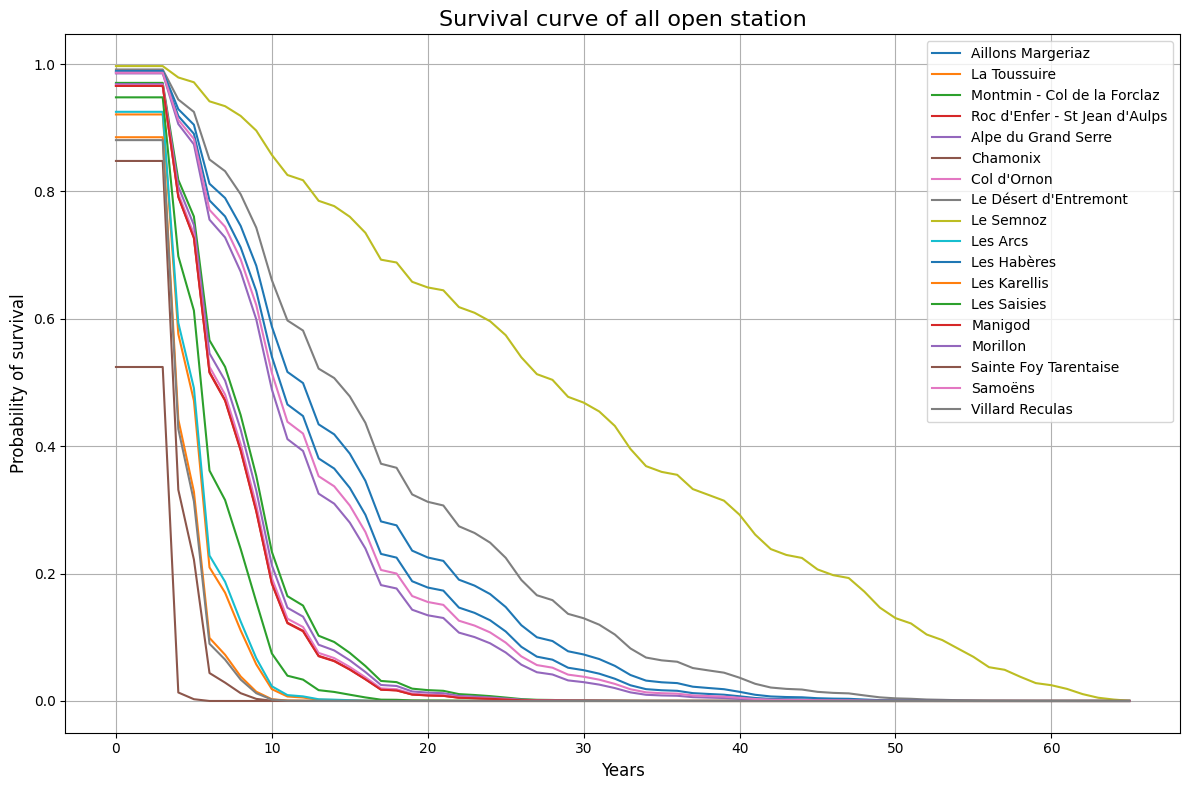

In [51]:
# Plot of all open station
plt.figure(figsize=(12, 8))

for idx, row in df_combined.iterrows():
    survie_values = row.iloc[:-1].values
    station_name = row.iloc[-1]
    plt.plot(survie_values, label=station_name)


plt.title("Survival curve of all open station", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Probability of survival", fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()